In [1]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.3f}'.format

from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.display.expand_frame_repr = False

In [2]:
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import chisquare
from scipy.stats import jarque_bera
from scipy.stats import cramervonmises
from scipy.stats import normaltest, norm
from scipy.stats import poisson
from scipy.stats import expon
from scipy.stats import anderson
from scipy.stats import zscore

In [3]:
from scipy.stats import ttest_ind
from scipy.stats import levene

In [4]:
def point_metrics(data_):
    conf = 0.95
    std = np.std(data_, ddof=1)
    mean = np.mean(data_)
    median = np.median(data_)
    print(f'Выборочное среднее == {mean}\n'
          f'Медианное значение == {median}\n'
          f'Стандартное отклонение == {std}\n'
          f'Выборочная дисперсия == {np.var(data_, ddof=1)}\n'
          f'I-ая квартиля == {np.percentile(data_, 25)}\n'
          f'II-ая квартиля == {np.percentile(data_, 75)}\n'
          f'Дов. Интервал с выборочным средним: {norm.interval(conf, loc=mean, scale=std)}\n'
          f'Дов. Интервал с медианным значением: {norm.interval(conf, loc=median, scale=std)}\n')


In [5]:
def fill_zeros(f_obs, f_exp):
    """ Fill zero bins """
    observed = []
    expected = []

    k = 0
    while k < len(f_exp):
        _f = f_obs[k]
        f_ = f_exp[k]
        while (_f == 0 or f_ == 0) and k < len(f_exp) - 1:
            k += 1
            _f += f_obs[k]
            f_ += f_exp[k]

        if (_f == 0 or f_ == 0) and k == len(f_exp) - 1:
            observed[-1] += _f
            expected[-1] += f_
        else:
            observed.append(_f)
            expected.append(f_)
        k += 1

    return observed, expected


def check_for_norm(data_):
    """ Check for normal distribution"""
    data_ = zscore(data_)

    observed_frequencies, bins = np.histogram(data_, bins='auto')
    standard_norm = np.random.normal(np.mean(data_), np.std(data_), len(data_))
    expected_frequencies, bins = np.histogram(standard_norm, bins=len(observed_frequencies))
    observed_frequencies, expected_frequencies = fill_zeros(observed_frequencies, expected_frequencies)
    print(sum(observed_frequencies), sum(expected_frequencies))
    print(observed_frequencies, expected_frequencies)

    chi = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    res = cramervonmises(data_, 'norm')
    anderson_stat, anderson_critical, significance_level = anderson(data_, dist='norm')

    v = [
        ['Chi-square', chi.statistic, chi.pvalue],
        ['D’Agostino and Pearson', *normaltest(data_, nan_policy='propagate')],
        ['Jarque-Bera', *jarque_bera(data_)],
        ['Shapiro-Wilk', *shapiro(data_)],
        ['Anderson', anderson_stat, anderson_critical[2]],
        [None, None, None],
        ['Cramér-von Mises', res.statistic, res.pvalue],  # not good for 'norm' 
        ['Kolmogorov-Smirnov', *kstest(data_, cdf=norm.cdf)],  # not good 'norm'
    ]

    return_df = pd.DataFrame(v, columns=['Method_Name', 'statistics', 'p_value'])
    print(return_df)


def check_for_exp(data_):
    """ Check for exponential distribution"""
    data_ = zscore(data_)

    observed_frequencies, bins = np.histogram(data_, bins='auto')
    standard_exp = np.random.exponential(scale=np.mean(data_), size=len(data_))
    expected_frequencies, bins = np.histogram(standard_exp, bins=len(observed_frequencies))
    observed_frequencies, expected_frequencies = fill_zeros(observed_frequencies, expected_frequencies)
    print(sum(observed_frequencies), sum(expected_frequencies))
    print(observed_frequencies, expected_frequencies)

    chi = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    v = (
        ['Kolmogorov-Smirnov', *kstest(data_, cdf=expon.cdf)],
        ['Chi-square', chi.statistic, chi.pvalue],
    )

    return_df = pd.DataFrame(v, columns=['Method_Name', 'statistics', 'p_value'])
    print(return_df)


def check_for_poisson(data_):
    """ Check for poisson distribution"""
    data_ = zscore(data_)

    observed_frequencies, bins = np.histogram(data_, bins='auto')
    standard_pois = np.random.poisson(np.mean(data_), len(data_))
    expected_frequencies, bins = np.histogram(standard_pois, bins=len(observed_frequencies))
    observed_frequencies, expected_frequencies = fill_zeros(observed_frequencies, expected_frequencies)
    print(sum(observed_frequencies), sum(expected_frequencies))
    print(observed_frequencies, expected_frequencies)

    chi = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    v = (
        ['Kolmogorov-Smirnov', *kstest(data_, poisson.cdf, args=(0.6,))],
        ['Chi-square', chi.statistic, chi.pvalue],
    )

    return_df = pd.DataFrame(v, columns=['Method_Name', 'statistics', 'p_value'])
    print(return_df)


In [6]:
def check_for_mean(list_1, list_2):
    """ Check for mean """
    list_1 = np.array(list_1)
    list_2 = np.array(list_2)
    list_short, list_long = (list_1, list_2) if len(list_1) < len(list_2) else (list_2, list_1)
    
    m = len(list_short)
    min_val = min(list_long)
    max_val = max(list_long)
    interval_width = (max_val - min_val) / m
    
    intervals = [[] for _ in range(m)]
    # Группировка элементов
    for element in list_long:
        interval_index = min(int((element - min_val) / interval_width), m - 1)
        intervals[interval_index].append(element)
    # Считаем среднее в интервалах
    list_long = [np.mean(interval) for interval in intervals]
    
    print(list_long)
    print(list_short)
    
    v = (
        ['T-tset', *ttest_ind(list_short, list_long)],
    )

    return_df = pd.DataFrame(v, columns=['Method_Name', 'statistics', 'p_value'])
    print(return_df)
    
    

In [7]:
def some_fun(l, axs, bins='auto', title=None):
    h_g = sns.histplot(data=l, bins=bins, discrete=False, kde=True, ax=axs)
    for p in h_g.patches:
        h_g.annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')
    h_g.set_title(title)

####

In [8]:
data = pd.DataFrame(columns=["Time",
                             "Sex",
                             "Birth weight in grams",
                             "Number of minutes after midnight"])

file = open('babyboom.dat.txt', 'r')

for line in file:
    words = line.split()
    data.loc[len(data.index)] = words

data["Time"] = data["Time"].astype(int)
data["Sex"] = data["Sex"].astype(int)
data["Birth weight in grams"] = data["Birth weight in grams"].astype(int)
data["Number of minutes after midnight"] = data["Number of minutes after midnight"].astype(int)
data.head(10)

,Time,Sex,Birth weight in grams,Number of minutes after midnight
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177
5,405,1,2208,245
6,407,1,1745,247
7,422,2,2846,262
8,431,2,3166,271
9,708,2,3520,428


### Исследуем вес младенцев на нормальность

Text(0.5, 1.0, 'The Boys vs. Normal')

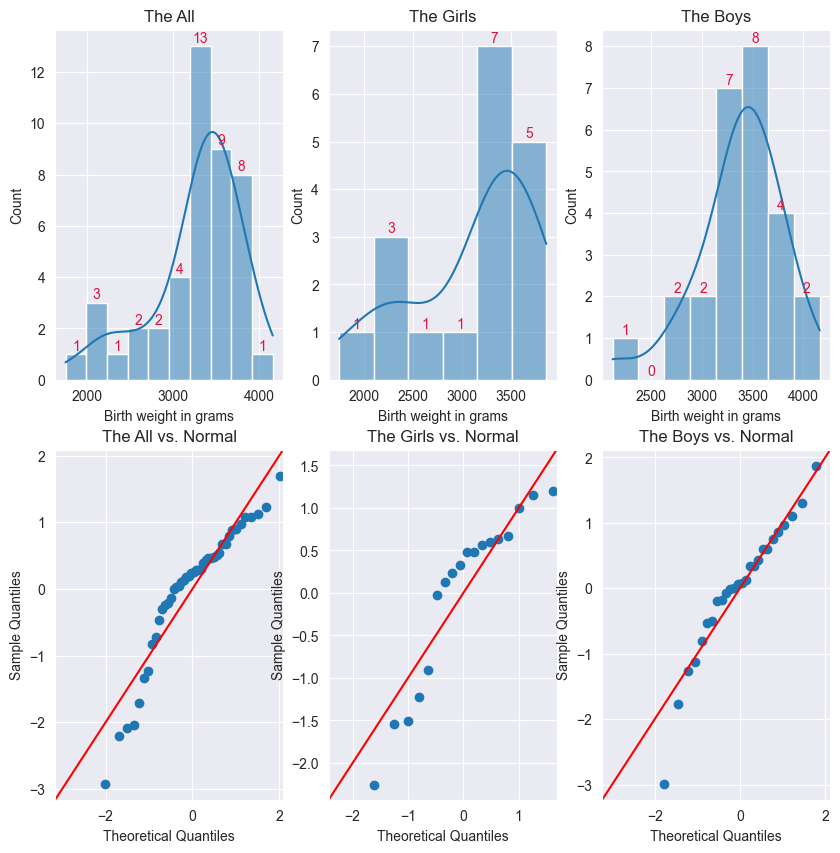

In [9]:
the_all = data["Birth weight in grams"]
the_girls = data[data["Sex"] == 1]["Birth weight in grams"]
the_boys = data[data["Sex"] == 2]["Birth weight in grams"]

fig_1, axs_1 = plt.subplots(ncols=3, nrows=2, figsize=(10, 10))

some_fun(l=the_all, title='The All', axs=axs_1[0][0])
some_fun(l=the_girls, title='The Girls', axs=axs_1[0][1])
some_fun(l=the_boys, title='The Boys', axs=axs_1[0][2])

qqplot(zscore(the_all), line='45', ax=axs_1[1][0])
axs_1[1, 0].set_title('The All vs. Normal')
qqplot(zscore(the_girls), line='45', ax=axs_1[1][1])
axs_1[1, 1].set_title('The Girls vs. Normal')
qqplot(zscore(the_boys), line='45', ax=axs_1[1][2])
axs_1[1, 2].set_title('The Boys vs. Normal')

In [10]:
print("Исследуем вес всех младенцев: ")
check_for_norm(the_all)
point_metrics(the_all)

print("Исследуем вес всех девочек: ")
check_for_norm(the_girls)
point_metrics(the_girls)

print("Исследуем вес всех мальчиков: ")
check_for_norm(the_boys)
point_metrics(the_boys)

Исследуем вес всех младенцев: 
44 44
[1, 3, 1, 2, 2, 4, 13, 9, 9] [1, 2, 2, 9, 10, 7, 7, 4, 2]
              Method_Name  statistics  p_value
0              Chi-square      50.023    0.000
1  D’Agostino and Pearson      10.774    0.005
2             Jarque-Bera      10.352    0.006
3            Shapiro-Wilk       0.899    0.001
4                Anderson       1.717    0.730
5                    None         NaN      NaN
6        Cramér-von Mises       0.310    0.127
7      Kolmogorov-Smirnov       0.183    0.091
Выборочное среднее == 3275.9545454545455
Медианное значение == 3404.0
Стандартное отклонение == 528.0324582405921
Выборочная дисперсия == 278818.27695560263
I-ая квартиля == 3141.5
II-ая квартиля == 3571.75
Дов. Интервал с выборочным средним: (2241.029944634835, 4310.879146274256)
Дов. Интервал с медианным значением: (2369.0753991802894, 4438.924600819711)

Исследуем вес всех девочек: 
18 18
[1, 3, 1, 1, 7, 5] [4, 4, 4, 2, 3, 1]
              Method_Name  statistics  p_value
0 

D:\PythonEnv\Matt\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Продолжаем исследовать демографию

Text(0.5, 1.0, 'The Births per-hour vs. Poisson')

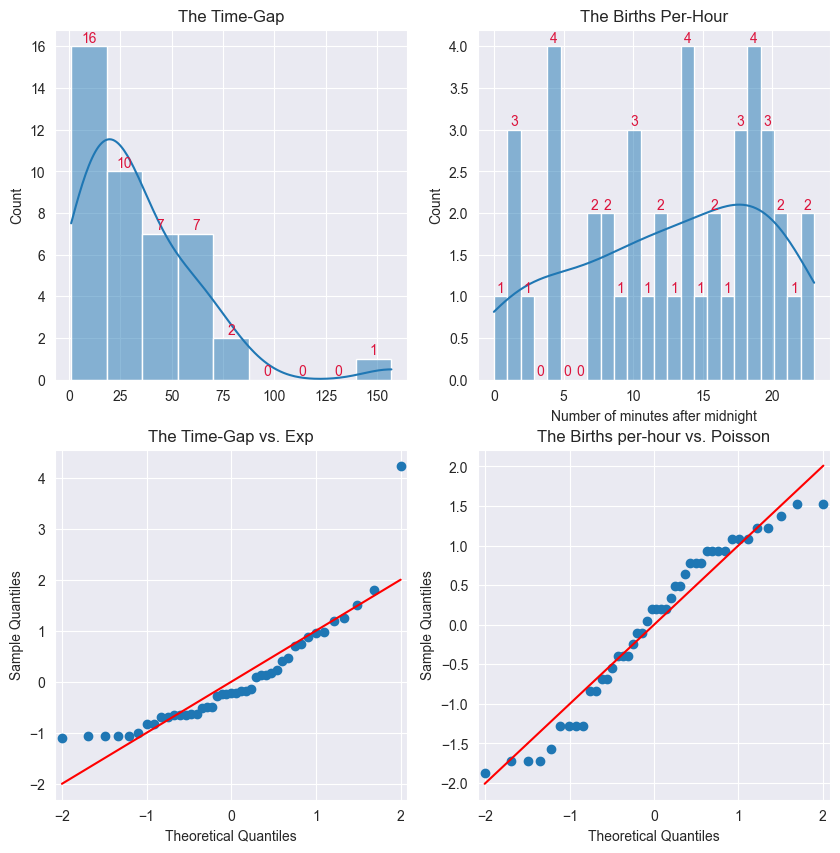

In [11]:
time = data["Number of minutes after midnight"].tolist()
the_gap = pd.Series([time[i + 1] - time[i] for i in range(len(time) - 1)])

the_births_per_hour = data["Number of minutes after midnight"].apply(lambda x: x // 60)

fig_2, axs_2 = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

some_fun(l=the_gap, title='The Time-Gap', axs=axs_2[0][0])
some_fun(l=the_births_per_hour, title='The Births Per-Hour', axs=axs_2[0][1], bins=24)

qqplot(zscore(the_gap), line='s', ax=axs_2[1][0])
axs_2[1, 0].set_title('The Time-Gap vs. Exp')
qqplot(zscore(the_births_per_hour), line='s', ax=axs_2[1][1])
axs_2[1, 1].set_title('The Births per-hour vs. Poisson')

In [12]:
print("Исследуем гэп между родами: ")
check_for_exp(the_gap)
point_metrics(the_gap)

print("Исследуем ко-во рождений в час: ")
check_for_poisson(the_births_per_hour)
point_metrics(the_births_per_hour)

Исследуем гэп между родами: 
43 43
[16, 10, 7, 7, 2, 1] [11, 9, 7, 4, 3, 9]
          Method_Name  statistics  p_value
0  Kolmogorov-Smirnov       0.605    0.000
1          Chi-square      12.078    0.034
Выборочное среднее == 33.25581395348837
Медианное значение == 27.0
Стандартное отклонение == 29.561149716071448
Выборочная дисперсия == 873.8615725359911
I-ая квартиля == 14.0
II-ая квартиля == 46.0
Дов. Интервал с выборочным средним: (-24.682974831608114, 91.19460273858485)
Дов. Интервал с медианным значением: (-30.938788785096484, 84.93878878509648)

Исследуем ко-во рождений в час: 
44 44
[44] [44]
          Method_Name  statistics  p_value
0  Kolmogorov-Smirnov       0.455    0.000
1          Chi-square       0.000      NaN
Выборочное среднее == 12.681818181818182
Медианное значение == 14.0
Стандартное отклонение == 6.870133295727026
Выборочная дисперсия == 47.19873150105708
I-ая квартиля == 7.75
II-ая квартиля == 19.0
Дов. Интервал с выборочным средним: (-0.7833956467962544, 26.14

### Проверяем гипотезы о равенстве средних и дисперсий 

In [13]:
print("Check for mean:")
print('statistics: {:.3f} p-value: {:.3f}'.format(*ttest_ind(the_girls, the_boys)))
print("Check for dispersion:")
print('statistics: {:.3f} p-value: {:.3f}'.format(*levene(the_girls, the_boys)))

Check for mean:
statistics: -1.523 p-value: 0.135
Check for dispersion:
statistics: 1.815 p-value: 0.185
